In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

# Redoing model selection with validation set

In [2]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)
df


,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


# First by splitting it according to time
The splitting will be 60:20:20


In [3]:
lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.15)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 15%

size2 = -int(len(Xinput)*(15/85))

Xtrain = Xinput.iloc[:size2].copy() #70%
Xvalidate = Xinput.iloc[size2:].copy() #15%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['HH Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['HH Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['HH Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)



In [4]:
print(len(trainXscaled))
print(len(validateXscaled))
print(len(testXscaled))
print(len(inputXscaled))

24260
5198
5198
29458


# Random Forest Regressor

In [5]:
N = range(10,1011,100)

RFR = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': N
}, cv=5, return_train_score=False)
RFR.fit(inputXscaled, inputy)

RFR_results = pd.DataFrame(RFR.cv_results_)
RFR_results = RFR_results[['param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
RFR_results

,param_n_estimators,mean_test_score,rank_test_score
7,710,0.841362,1
5,510,0.841325,2
6,610,0.841283,3
8,810,0.841259,4
4,410,0.841253,5
9,910,0.841235,6
2,210,0.841170,7
10,1010,0.841114,8
3,310,0.841084,9
1,110,0.840519,10


In [6]:
N = range(5,96,10)

RFR1 = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': N
}, cv=5, return_train_score=False)
RFR1.fit(inputXscaled, inputy)

RFRresults1 = pd.DataFrame(RFR1.cv_results_)
RFRresults1 = RFRresults1[['param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
RFRresults1



,param_n_estimators,mean_test_score,rank_test_score
8,85,0.840685,1
9,95,0.840533,2
7,75,0.840526,3
6,65,0.840202,4
5,55,0.839982,5
4,45,0.839152,6
3,35,0.838360,7
2,25,0.837394,8
1,15,0.833840,9
0,5,0.819302,10


In [7]:
RFRresults2 = RFR_results.copy()
RFRresults = RFRresults2.append(RFRresults1)
RFRresults = RFRresults.sort_values(by=['mean_test_score'])
RFRresults


,param_n_estimators,mean_test_score,rank_test_score
0,5,0.819302,10
0,10,0.828919,11
1,15,0.833840,9
2,25,0.837394,8
3,35,0.838360,7
4,45,0.839152,6
5,55,0.839982,5
6,65,0.840202,4
1,110,0.840519,10
7,75,0.840526,3


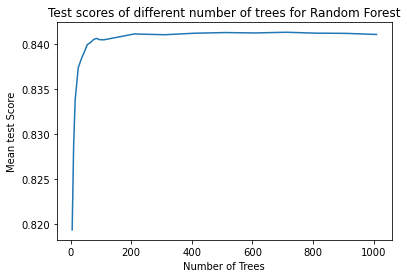

In [8]:
RFRresults = RFRresults.sort_values(by=['param_n_estimators'])
plt.plot(RFRresults['param_n_estimators'], RFRresults['mean_test_score'])

plt.xlabel('Number of Trees')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores of different number of trees for Random Forest')
# Display a figure.
plt.show()

8.797086538027425


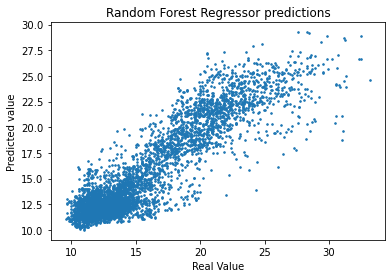

In [17]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

RandomForestMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

8.797086538027425


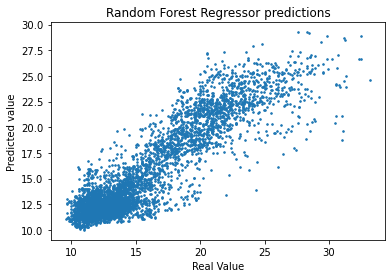

In [35]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

RandomForestMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

8.797086538027425


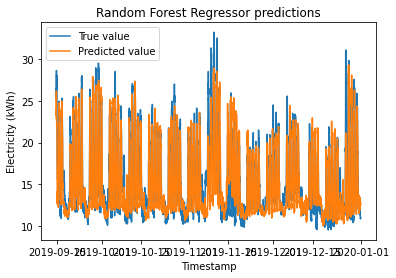

In [16]:
pred = estimator.predict(validateXscaled)

RandomForestMAPE = mean_absolute_percentage_error(validatey, pred) * 100
print(RandomForestMAPE)

plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],validatey, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

# Visualization examples

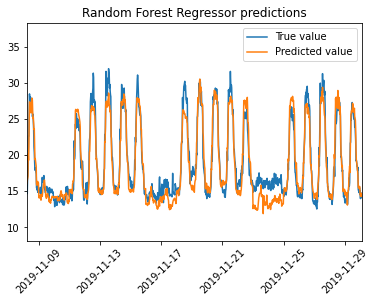

In [19]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+4350], df['From Timestamp'].iloc[size+5400])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

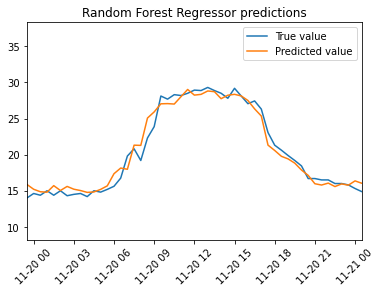

In [30]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+4914], df['From Timestamp'].iloc[size+4964])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

Looks decent but on other parts:

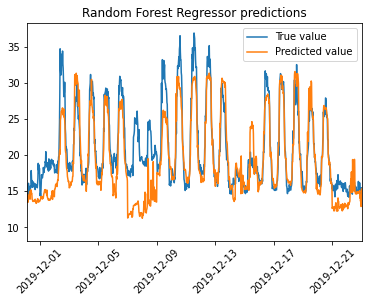

In [15]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+5400], df['From Timestamp'].iloc[size+6500])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

This should be the worst part

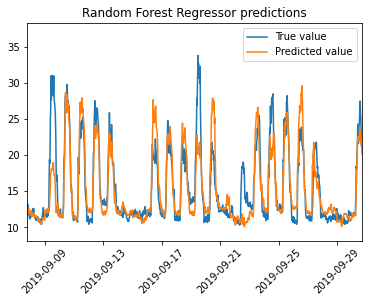

In [158]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+1400], df['From Timestamp'].iloc[size+2500])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

what is that random spike during the weekend between the 2nd and 3rd week

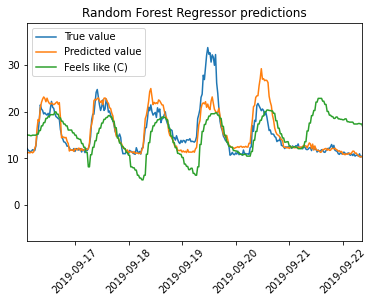

In [37]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.plot(df['From Timestamp'].iloc[size:],df['Feels like (C)'].iloc[size:], label = "Feels like (C)")
plt.xlim(df['From Timestamp'].iloc[size+1800], df['From Timestamp'].iloc[size+2100])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

### Unless we consider "International Talk like a Pirate Day" to be a special day there is no information/data that would justify the unusual behaviour on that day

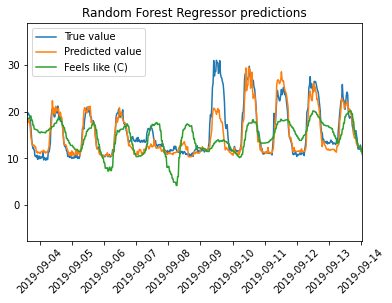

In [40]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.plot(df['From Timestamp'].iloc[size:],df['Feels like (C)'].iloc[size:], label = "Feels like (C)")
plt.xlim(df['From Timestamp'].iloc[size+1200], df['From Timestamp'].iloc[size+1700])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

# With the code below we search for interesting points to analyse with SHAP in the jupyter notebook 2.3

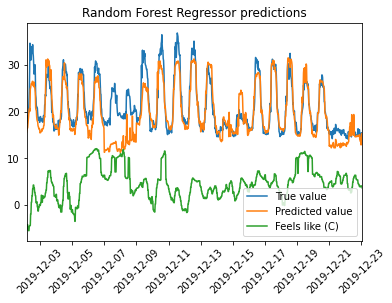

In [102]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.plot(df['From Timestamp'].iloc[size:],df['Feels like (C)'].iloc[size:], label = "Feels like (C)")
plt.xlim(df['From Timestamp'].iloc[size+5500], df['From Timestamp'].iloc[size+6500])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

# Interesting to note the last week: First Spike underestimated but then it catches up.

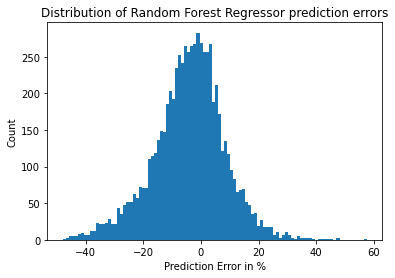

In [155]:
error = 100*(pred - testy)/testy
plt.hist(error, bins=100)
plt.title('Distribution of Random Forest Regressor prediction errors')
plt.xlabel('Prediction Error in %')
_ = plt.ylabel('Count')

## When experimenting with the visualization I found an interesting point. It seems like the data is still not *clean*

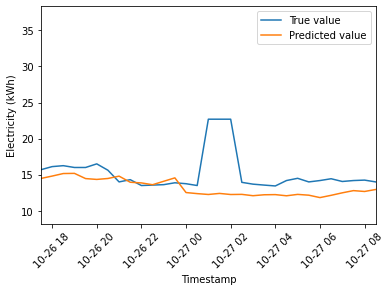

In [97]:
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+3750], df['From Timestamp'].iloc[size+3780])
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

# KNN


In [53]:
N = range(1,150,1)

KNN = GridSearchCV(KNeighborsRegressor(), {
    'n_neighbors': N,
    'weights': ['uniform', 'distance']
}, cv=5, return_train_score=False, verbose = 3)
KNN.fit(inputXscaled, inputy)
KNN_results = pd.DataFrame(KNN.cv_results_)
KNN_results = KNN_results[['param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
KNN_results

Fitting 5 folds for each of 298 candidates, totalling 1490 fits
[CV 1/5] END .................n_neighbors=1, weights=uniform; total time=   1.3s
[CV 2/5] END .................n_neighbors=1, weights=uniform; total time=   1.6s
[CV 3/5] END .................n_neighbors=1, weights=uniform; total time=   1.2s
[CV 4/5] END .................n_neighbors=1, weights=uniform; total time=   1.0s
[CV 5/5] END .................n_neighbors=1, weights=uniform; total time=   1.0s
[CV 1/5] END ................n_neighbors=1, weights=distance; total time=   1.3s
[CV 2/5] END ................n_neighbors=1, weights=distance; total time=   1.5s
[CV 3/5] END ................n_neighbors=1, weights=distance; total time=   1.4s
[CV 4/5] END ................n_neighbors=1, weights=distance; total time=   1.1s
[CV 5/5] END ................n_neighbors=1, weights=distance; total time=   1.9s
[CV 1/5] END .................n_neighbors=2, weights=uniform; total time=   1.5s
[CV 2/5] END .................n_neighbors=2, 

[CV 2/5] END ................n_neighbors=11, weights=uniform; total time=   1.5s
[CV 3/5] END ................n_neighbors=11, weights=uniform; total time=   1.4s
[CV 4/5] END ................n_neighbors=11, weights=uniform; total time=   1.2s
[CV 5/5] END ................n_neighbors=11, weights=uniform; total time=   1.3s
[CV 1/5] END ...............n_neighbors=11, weights=distance; total time=   1.3s
[CV 2/5] END ...............n_neighbors=11, weights=distance; total time=   1.5s
[CV 3/5] END ...............n_neighbors=11, weights=distance; total time=   1.5s
[CV 4/5] END ...............n_neighbors=11, weights=distance; total time=   1.2s
[CV 5/5] END ...............n_neighbors=11, weights=distance; total time=   1.2s
[CV 1/5] END ................n_neighbors=12, weights=uniform; total time=   1.3s
[CV 2/5] END ................n_neighbors=12, weights=uniform; total time=   1.5s
[CV 3/5] END ................n_neighbors=12, weights=uniform; total time=   1.6s
[CV 4/5] END ...............

[CV 4/5] END ................n_neighbors=21, weights=uniform; total time=   1.4s
[CV 5/5] END ................n_neighbors=21, weights=uniform; total time=   1.4s
[CV 1/5] END ...............n_neighbors=21, weights=distance; total time=   1.4s
[CV 2/5] END ...............n_neighbors=21, weights=distance; total time=   1.6s
[CV 3/5] END ...............n_neighbors=21, weights=distance; total time=   1.6s
[CV 4/5] END ...............n_neighbors=21, weights=distance; total time=   1.3s
[CV 5/5] END ...............n_neighbors=21, weights=distance; total time=   1.4s
[CV 1/5] END ................n_neighbors=22, weights=uniform; total time=   1.4s
[CV 2/5] END ................n_neighbors=22, weights=uniform; total time=   1.6s
[CV 3/5] END ................n_neighbors=22, weights=uniform; total time=   1.6s
[CV 4/5] END ................n_neighbors=22, weights=uniform; total time=   1.3s
[CV 5/5] END ................n_neighbors=22, weights=uniform; total time=   1.4s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=31, weights=distance; total time=   1.8s
[CV 2/5] END ...............n_neighbors=31, weights=distance; total time=   1.8s
[CV 3/5] END ...............n_neighbors=31, weights=distance; total time=   1.9s
[CV 4/5] END ...............n_neighbors=31, weights=distance; total time=   1.4s
[CV 5/5] END ...............n_neighbors=31, weights=distance; total time=   1.5s
[CV 1/5] END ................n_neighbors=32, weights=uniform; total time=   1.5s
[CV 2/5] END ................n_neighbors=32, weights=uniform; total time=   1.7s
[CV 3/5] END ................n_neighbors=32, weights=uniform; total time=   1.8s
[CV 4/5] END ................n_neighbors=32, weights=uniform; total time=   1.5s
[CV 5/5] END ................n_neighbors=32, weights=uniform; total time=   1.5s
[CV 1/5] END ...............n_neighbors=32, weights=distance; total time=   1.5s
[CV 2/5] END ...............n_neighbors=32, weights=distance; total time=   1.7s
[CV 3/5] END ...............

[CV 3/5] END ...............n_neighbors=41, weights=distance; total time=   1.9s
[CV 4/5] END ...............n_neighbors=41, weights=distance; total time=   1.5s
[CV 5/5] END ...............n_neighbors=41, weights=distance; total time=   1.5s
[CV 1/5] END ................n_neighbors=42, weights=uniform; total time=   1.6s
[CV 2/5] END ................n_neighbors=42, weights=uniform; total time=   1.8s
[CV 3/5] END ................n_neighbors=42, weights=uniform; total time=   1.9s
[CV 4/5] END ................n_neighbors=42, weights=uniform; total time=   1.5s
[CV 5/5] END ................n_neighbors=42, weights=uniform; total time=   1.6s
[CV 1/5] END ...............n_neighbors=42, weights=distance; total time=   1.6s
[CV 2/5] END ...............n_neighbors=42, weights=distance; total time=   1.9s
[CV 3/5] END ...............n_neighbors=42, weights=distance; total time=   2.0s
[CV 4/5] END ...............n_neighbors=42, weights=distance; total time=   1.5s
[CV 5/5] END ...............

[CV 5/5] END ...............n_neighbors=51, weights=distance; total time=   1.6s
[CV 1/5] END ................n_neighbors=52, weights=uniform; total time=   1.7s
[CV 2/5] END ................n_neighbors=52, weights=uniform; total time=   1.9s
[CV 3/5] END ................n_neighbors=52, weights=uniform; total time=   2.0s
[CV 4/5] END ................n_neighbors=52, weights=uniform; total time=   1.6s
[CV 5/5] END ................n_neighbors=52, weights=uniform; total time=   1.6s
[CV 1/5] END ...............n_neighbors=52, weights=distance; total time=   1.7s
[CV 2/5] END ...............n_neighbors=52, weights=distance; total time=   1.9s
[CV 3/5] END ...............n_neighbors=52, weights=distance; total time=   2.0s
[CV 4/5] END ...............n_neighbors=52, weights=distance; total time=   1.6s
[CV 5/5] END ...............n_neighbors=52, weights=distance; total time=   1.7s
[CV 1/5] END ................n_neighbors=53, weights=uniform; total time=   1.8s
[CV 2/5] END ...............

[CV 2/5] END ................n_neighbors=62, weights=uniform; total time=   2.0s
[CV 3/5] END ................n_neighbors=62, weights=uniform; total time=   2.2s
[CV 4/5] END ................n_neighbors=62, weights=uniform; total time=   1.6s
[CV 5/5] END ................n_neighbors=62, weights=uniform; total time=   1.8s
[CV 1/5] END ...............n_neighbors=62, weights=distance; total time=   1.7s
[CV 2/5] END ...............n_neighbors=62, weights=distance; total time=   2.0s
[CV 3/5] END ...............n_neighbors=62, weights=distance; total time=   2.2s
[CV 4/5] END ...............n_neighbors=62, weights=distance; total time=   1.7s
[CV 5/5] END ...............n_neighbors=62, weights=distance; total time=   1.7s
[CV 1/5] END ................n_neighbors=63, weights=uniform; total time=   1.7s
[CV 2/5] END ................n_neighbors=63, weights=uniform; total time=   2.0s
[CV 3/5] END ................n_neighbors=63, weights=uniform; total time=   2.1s
[CV 4/5] END ...............

[CV 4/5] END ................n_neighbors=72, weights=uniform; total time=   1.7s
[CV 5/5] END ................n_neighbors=72, weights=uniform; total time=   1.8s
[CV 1/5] END ...............n_neighbors=72, weights=distance; total time=   2.0s
[CV 2/5] END ...............n_neighbors=72, weights=distance; total time=   2.2s
[CV 3/5] END ...............n_neighbors=72, weights=distance; total time=   2.2s
[CV 4/5] END ...............n_neighbors=72, weights=distance; total time=   1.7s
[CV 5/5] END ...............n_neighbors=72, weights=distance; total time=   1.8s
[CV 1/5] END ................n_neighbors=73, weights=uniform; total time=   1.8s
[CV 2/5] END ................n_neighbors=73, weights=uniform; total time=   2.2s
[CV 3/5] END ................n_neighbors=73, weights=uniform; total time=   2.2s
[CV 4/5] END ................n_neighbors=73, weights=uniform; total time=   1.7s
[CV 5/5] END ................n_neighbors=73, weights=uniform; total time=   1.8s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=82, weights=distance; total time=   1.9s
[CV 2/5] END ...............n_neighbors=82, weights=distance; total time=   4.1s
[CV 3/5] END ...............n_neighbors=82, weights=distance; total time=   2.9s
[CV 4/5] END ...............n_neighbors=82, weights=distance; total time=   2.7s
[CV 5/5] END ...............n_neighbors=82, weights=distance; total time=   2.8s
[CV 1/5] END ................n_neighbors=83, weights=uniform; total time=   3.3s
[CV 2/5] END ................n_neighbors=83, weights=uniform; total time=   2.3s
[CV 3/5] END ................n_neighbors=83, weights=uniform; total time=   2.3s
[CV 4/5] END ................n_neighbors=83, weights=uniform; total time=   1.8s
[CV 5/5] END ................n_neighbors=83, weights=uniform; total time=   1.8s
[CV 1/5] END ...............n_neighbors=83, weights=distance; total time=   1.9s
[CV 2/5] END ...............n_neighbors=83, weights=distance; total time=   2.3s
[CV 3/5] END ...............

[CV 3/5] END ...............n_neighbors=92, weights=distance; total time=   2.4s
[CV 4/5] END ...............n_neighbors=92, weights=distance; total time=   1.8s
[CV 5/5] END ...............n_neighbors=92, weights=distance; total time=   1.9s
[CV 1/5] END ................n_neighbors=93, weights=uniform; total time=   1.9s
[CV 2/5] END ................n_neighbors=93, weights=uniform; total time=   2.2s
[CV 3/5] END ................n_neighbors=93, weights=uniform; total time=   2.4s
[CV 4/5] END ................n_neighbors=93, weights=uniform; total time=   1.8s
[CV 5/5] END ................n_neighbors=93, weights=uniform; total time=   2.2s
[CV 1/5] END ...............n_neighbors=93, weights=distance; total time=   2.0s
[CV 2/5] END ...............n_neighbors=93, weights=distance; total time=   2.2s
[CV 3/5] END ...............n_neighbors=93, weights=distance; total time=   2.4s
[CV 4/5] END ...............n_neighbors=93, weights=distance; total time=   1.9s
[CV 5/5] END ...............

[CV 5/5] END ..............n_neighbors=102, weights=distance; total time=   2.2s
[CV 1/5] END ...............n_neighbors=103, weights=uniform; total time=   2.0s
[CV 2/5] END ...............n_neighbors=103, weights=uniform; total time=   2.3s
[CV 3/5] END ...............n_neighbors=103, weights=uniform; total time=   2.5s
[CV 4/5] END ...............n_neighbors=103, weights=uniform; total time=   1.9s
[CV 5/5] END ...............n_neighbors=103, weights=uniform; total time=   2.0s
[CV 1/5] END ..............n_neighbors=103, weights=distance; total time=   2.0s
[CV 2/5] END ..............n_neighbors=103, weights=distance; total time=   2.3s
[CV 3/5] END ..............n_neighbors=103, weights=distance; total time=   2.5s
[CV 4/5] END ..............n_neighbors=103, weights=distance; total time=   1.9s
[CV 5/5] END ..............n_neighbors=103, weights=distance; total time=   1.9s
[CV 1/5] END ...............n_neighbors=104, weights=uniform; total time=   2.0s
[CV 2/5] END ...............

[CV 2/5] END ...............n_neighbors=113, weights=uniform; total time=   2.5s
[CV 3/5] END ...............n_neighbors=113, weights=uniform; total time=   3.1s
[CV 4/5] END ...............n_neighbors=113, weights=uniform; total time=   2.1s
[CV 5/5] END ...............n_neighbors=113, weights=uniform; total time=   2.0s
[CV 1/5] END ..............n_neighbors=113, weights=distance; total time=   2.1s
[CV 2/5] END ..............n_neighbors=113, weights=distance; total time=   2.9s
[CV 3/5] END ..............n_neighbors=113, weights=distance; total time=   2.5s
[CV 4/5] END ..............n_neighbors=113, weights=distance; total time=   2.0s
[CV 5/5] END ..............n_neighbors=113, weights=distance; total time=   2.2s
[CV 1/5] END ...............n_neighbors=114, weights=uniform; total time=   2.0s
[CV 2/5] END ...............n_neighbors=114, weights=uniform; total time=   2.4s
[CV 3/5] END ...............n_neighbors=114, weights=uniform; total time=   2.5s
[CV 4/5] END ...............

[CV 4/5] END ...............n_neighbors=123, weights=uniform; total time=   2.1s
[CV 5/5] END ...............n_neighbors=123, weights=uniform; total time=   2.2s
[CV 1/5] END ..............n_neighbors=123, weights=distance; total time=   2.2s
[CV 2/5] END ..............n_neighbors=123, weights=distance; total time=   2.5s
[CV 3/5] END ..............n_neighbors=123, weights=distance; total time=   2.8s
[CV 4/5] END ..............n_neighbors=123, weights=distance; total time=   2.1s
[CV 5/5] END ..............n_neighbors=123, weights=distance; total time=   2.2s
[CV 1/5] END ...............n_neighbors=124, weights=uniform; total time=   2.2s
[CV 2/5] END ...............n_neighbors=124, weights=uniform; total time=   2.5s
[CV 3/5] END ...............n_neighbors=124, weights=uniform; total time=   2.7s
[CV 4/5] END ...............n_neighbors=124, weights=uniform; total time=   2.4s
[CV 5/5] END ...............n_neighbors=124, weights=uniform; total time=   2.2s
[CV 1/5] END ..............n

[CV 1/5] END ..............n_neighbors=133, weights=distance; total time=   2.2s
[CV 2/5] END ..............n_neighbors=133, weights=distance; total time=   2.6s
[CV 3/5] END ..............n_neighbors=133, weights=distance; total time=   2.8s
[CV 4/5] END ..............n_neighbors=133, weights=distance; total time=   2.2s
[CV 5/5] END ..............n_neighbors=133, weights=distance; total time=   2.4s
[CV 1/5] END ...............n_neighbors=134, weights=uniform; total time=   2.3s
[CV 2/5] END ...............n_neighbors=134, weights=uniform; total time=   2.6s
[CV 3/5] END ...............n_neighbors=134, weights=uniform; total time=   2.8s
[CV 4/5] END ...............n_neighbors=134, weights=uniform; total time=   2.1s
[CV 5/5] END ...............n_neighbors=134, weights=uniform; total time=   2.2s
[CV 1/5] END ..............n_neighbors=134, weights=distance; total time=   2.3s
[CV 2/5] END ..............n_neighbors=134, weights=distance; total time=   2.6s
[CV 3/5] END ..............n

[CV 3/5] END ..............n_neighbors=143, weights=distance; total time=   2.8s
[CV 4/5] END ..............n_neighbors=143, weights=distance; total time=   2.2s
[CV 5/5] END ..............n_neighbors=143, weights=distance; total time=   2.3s
[CV 1/5] END ...............n_neighbors=144, weights=uniform; total time=   2.3s
[CV 2/5] END ...............n_neighbors=144, weights=uniform; total time=   2.6s
[CV 3/5] END ...............n_neighbors=144, weights=uniform; total time=   3.0s
[CV 4/5] END ...............n_neighbors=144, weights=uniform; total time=   2.2s
[CV 5/5] END ...............n_neighbors=144, weights=uniform; total time=   2.3s
[CV 1/5] END ..............n_neighbors=144, weights=distance; total time=   2.3s
[CV 2/5] END ..............n_neighbors=144, weights=distance; total time=   2.7s
[CV 3/5] END ..............n_neighbors=144, weights=distance; total time=   2.8s
[CV 4/5] END ..............n_neighbors=144, weights=distance; total time=   2.2s
[CV 5/5] END ..............n

,param_n_neighbors,param_weights,mean_test_score,rank_test_score
211,106,distance,0.841115,1
219,110,distance,0.841112,2
215,108,distance,0.841111,3
207,104,distance,0.841110,4
217,109,distance,0.841108,5
...,...,...,...,...
5,3,distance,0.774239,294
3,2,distance,0.762011,295
2,2,uniform,0.761906,296
1,1,distance,0.736010,297


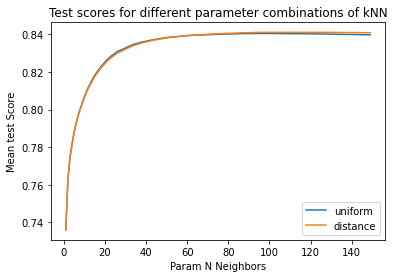

In [54]:
KNNuniform = KNN_results[(KNN_results['param_weights'] == 'uniform' )].sort_values(by = ['param_n_neighbors'])
KNNdistance = KNN_results[(KNN_results['param_weights'] == 'distance' )].sort_values(by = ['param_n_neighbors'])

plt.plot(KNNuniform['param_n_neighbors'], KNNuniform['mean_test_score'], label = 'uniform')
plt.plot(KNNdistance['param_n_neighbors'], KNNdistance['mean_test_score'], label = 'distance')

plt.xlabel('Param N Neighbors')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores for different parameter combinations of kNN')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

8.644952328098336


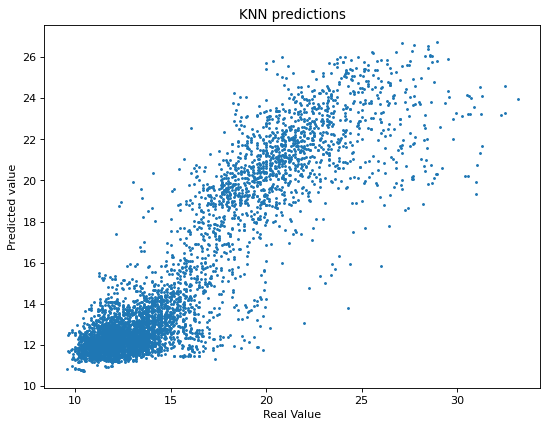

In [18]:
estimator = KNeighborsRegressor(n_neighbors = 104, weights = 'distance').fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

KNNMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(KNNMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('KNN predictions')
# Display a figure.
plt.show()

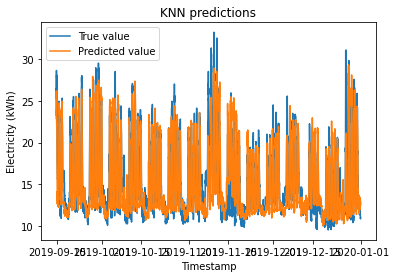

In [19]:
plt.title('KNN predictions')
plt.plot(df['From Timestamp'].iloc[size:],validatey, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()


# SVM Regression

In [61]:
SVM = GridSearchCV(svm.SVR(gamma='scale'), {
    'C': [0.01, 0.1, 1, 100], 
    'kernel': ['rbf','linear'],
    'epsilon': [0.01,0.1,1,10]
}, cv=5, return_train_score=False, verbose = 4)
SVM.fit(inputXscaled, inputy)

svm_results = pd.DataFrame(SVM.cv_results_)
svmresults = svm_results[['param_kernel','param_C','param_epsilon', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
svmresults

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  50.4s
[CV 2/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  49.9s
[CV 3/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  49.8s
[CV 4/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  50.1s
[CV 5/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  51.3s
[CV 1/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  27.9s
[CV 2/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  28.0s
[CV 3/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  27.5s
[CV 4/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  27.6s
[CV 5/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  27.6s
[CV 1/5] END ................C=0.01, epsilon=0.1, kernel=rbf; total time=  48.3s
[CV 2/5] END ................C=0.01, epsilon=0.

[CV 2/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  24.3s
[CV 3/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  23.4s
[CV 4/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  23.1s
[CV 5/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  24.0s
[CV 1/5] END ..................C=1, epsilon=1, kernel=linear; total time=  24.0s
[CV 2/5] END ..................C=1, epsilon=1, kernel=linear; total time=  24.6s
[CV 3/5] END ..................C=1, epsilon=1, kernel=linear; total time=  24.3s
[CV 4/5] END ..................C=1, epsilon=1, kernel=linear; total time=  23.8s
[CV 5/5] END ..................C=1, epsilon=1, kernel=linear; total time=  24.2s
[CV 1/5] END ....................C=1, epsilon=10, kernel=rbf; total time=   0.1s
[CV 2/5] END ....................C=1, epsilon=10, kernel=rbf; total time=   0.1s
[CV 3/5] END ....................C=1, epsilon=10, kernel=rbf; total time=   0.1s
[CV 4/5] END ...............

,param_kernel,param_C,param_epsilon,mean_test_score,rank_test_score
18,rbf,1,0.1,0.828788,1
20,rbf,1,1,0.828589,2
16,rbf,1,0.01,0.828549,3
10,rbf,0.1,0.1,0.818895,4
8,rbf,0.1,0.01,0.818780,5
12,rbf,0.1,1,0.818037,6
5,linear,0.01,1,0.781346,7
13,linear,0.1,1,0.781116,8
29,linear,100,1,0.781014,9
21,linear,1,1,0.780989,10


8.358734313137349


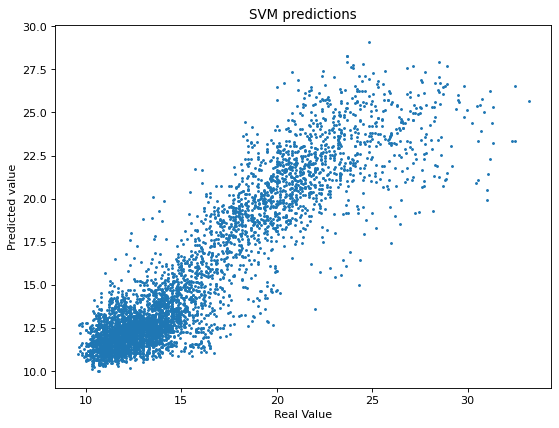

In [21]:
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X1scaled,y1,test_size=0.25,random_state=42) #split training:testing 75:25


estimator = svm.SVR(C = 1,  kernel = 'rbf', epsilon = 0.1).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

SVMMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions')
# Display a figure.
plt.show()

8.358734313137349


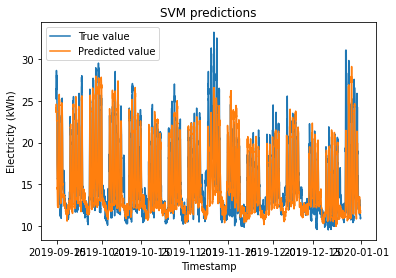

In [23]:
pred = estimator.predict(validateXscaled)

SVMMAPE = mean_absolute_percentage_error(validatey, pred) * 100
print(SVMMAPE)

plt.title('SVM predictions')
plt.plot(df['From Timestamp'].iloc[size:],validatey, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()


# Multilayer perceptron

In [66]:
from sklearn.neural_network import MLPRegressor

layers = range(1,35)

parameters = {'hidden_layer_sizes': layers, 'solver': ['lbfgs', 'adam'], 'max_iter': [3000], 'learning_rate_init': 10.0 ** -np.arange(1, 6, 2), 'random_state':[42]}
MLPReg = GridSearchCV(MLPRegressor(), parameters, cv=5,  verbose=2, return_train_score=False)
MLPReg.fit(inputXscaled, inputy)

MLPRegRes = pd.DataFrame(MLPReg.cv_results_)
MLP_results = MLPRegRes[['rank_test_score', 'mean_test_score', 'param_hidden_layer_sizes', 'param_solver', 'param_max_iter', 'param_learning_rate_init']].sort_values(by=['rank_test_score'])
MLP_results

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.3s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.2s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.6s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.5s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.3s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.0s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.8s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=2, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.8s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.4s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.4s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.1s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.5s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=3, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.7s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.4s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.4s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.4s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.5s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s
[CV] END hidden_layer_sizes=4, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.7s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.9s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.1s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.3s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.3s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.6s
[CV] END hidden_layer_sizes=5, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   5.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.8s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.6s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.6s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.5s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=6, learning_rate_

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.9s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.6s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  11.8s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  13.8s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  10.0s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  11.9s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  10.9s
[CV] END hidden_layer_sizes=6

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.8s
[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.7s
[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.1s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   9.5s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.0s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.5s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.8s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=7, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   9.5s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.0s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  10.1s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  11.3s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.1s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=8, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.1s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   5.3s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.6s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.0s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   8.6s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.8s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=9, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.8s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.2s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   8.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  11.9s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=10, lea

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.0s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.9s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   8.9s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  15.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  10.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  21.2s
[CV] END hidden_lay

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.1s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.0s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   8.7s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.8s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.3s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.9s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.5s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.6s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.6s
[CV] END hidden_layer_sizes=11, l

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.2s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.8s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.8s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.5s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.2s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  12.5s
[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.8s
[CV] END hidden_layer

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.6s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.9s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.6s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.2s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.8s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.2s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  11.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.5s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.9s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  12.2s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.1s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.0s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.0s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.2s
[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.9s
[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.3s
[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.1s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.3s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.1s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.8s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.9s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  13.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  15.0s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.8s
[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.6s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.0s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  28.5s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.6s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.7s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.0s
[CV] END hidden_layer_sizes=14, l

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  28.5s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  12.1s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  28.6s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.1s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  11.9s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.1s
[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.7s
[CV] END hidden_layer

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.7s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.5s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  12.9s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  21.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  31.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.4s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.7s
[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.3s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.9s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.0s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  21.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.6s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  15.0s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  10.6s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  10.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min
[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.4s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.8s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.0s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.4s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.7s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  13.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.0s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.7s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  13.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.6s
[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.6s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.2s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  30.0s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.3s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.3s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min
[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.7s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.2s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.0s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.8s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.8s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.3s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.3s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  26.0s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.6s
[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.3s
[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.8s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.9s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.3s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.8s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.5s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.7s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.4s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.3s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.1s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.0s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  29.9s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  12.7s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.0s
[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.5s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.4s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.6s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.6s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=22, lear

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.3s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.8s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.7s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.7s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  29.9s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.9s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.6s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  31.0s
[CV] END hidden_laye

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.2s
[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.8s
[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.2s
[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.3s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.6s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  13.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  28.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min
[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.0s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.8s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.9s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.0s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.6s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.5s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  26.3s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.8s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  31.9s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.7s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.5s
[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.6s
[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.8s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.7s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  21.8s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.3s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.6s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.2s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.9s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.3s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.4s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.2s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.7s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  15.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  45.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.4s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.5s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  50.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.9s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  21.6s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.6s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.1s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.7s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  46.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.9s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.1s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.9s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  50.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.2s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.3s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.8s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.5s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.6s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  23.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  48.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  52.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  50.9s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.5s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.1s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  52.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.4s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.2s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  21.3s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.9s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.0s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  14.7s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  52.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  50.8s
[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  50.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  51.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  53.7s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  49.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  53.6s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.9s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.4s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.6s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.2s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  55.2s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  29.6s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  25.2s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.6s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.7s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  27.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  52.7s
[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  47.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  53.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  53.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.0s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.4s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.8s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.6s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.3s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.2s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  54.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.7s
[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.1s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.5s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.8s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.4s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.6s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  26.8s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  19.2s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  26.3s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.1s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  55.9s
[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  55.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.3s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   5.2s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  55.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  56.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.8s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.3s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  18.8s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.2s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.5s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  57.3s
[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min
[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min
[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.0s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.8s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.2s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.2s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  25.6s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.3s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  17.9s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  59.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  58.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.7min


,rank_test_score,mean_test_score,param_hidden_layer_sizes,param_solver,param_max_iter,param_learning_rate_init
24,1,0.853506,5,lbfgs,3000,0.1
26,1,0.853506,5,lbfgs,3000,0.001
28,1,0.853506,5,lbfgs,3000,0.00001
21,4,0.851356,4,adam,3000,0.001
191,5,0.848317,32,adam,3000,0.00001
...,...,...,...,...,...,...
4,199,0.495541,1,lbfgs,3000,0.00001
0,199,0.495541,1,lbfgs,3000,0.1
3,202,-0.097901,1,adam,3000,0.001
11,203,-1.258332,2,adam,3000,0.00001


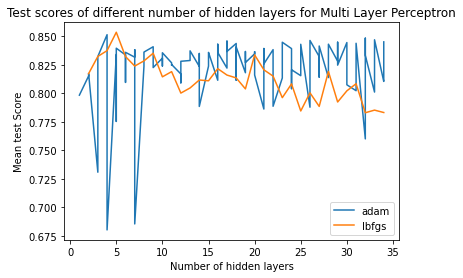

In [67]:
MLP_results1 = MLP_results[MLP_results['mean_test_score']>0.5]


MLP_adam = MLP_results1[(MLP_results1['param_solver'] == 'adam' )].sort_values(by = ['param_hidden_layer_sizes'])
MLP_lbfgs = MLP_results1[(MLP_results1['param_solver'] == 'lbfgs' )].sort_values(by = ['param_hidden_layer_sizes'])

plt.plot(MLP_adam['param_hidden_layer_sizes'], MLP_adam['mean_test_score'], label = 'adam')
plt.plot(MLP_lbfgs['param_hidden_layer_sizes'], MLP_lbfgs['mean_test_score'], label = 'lbfgs')

plt.xlabel('Number of hidden layers')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores of different number of hidden layers for Multi Layer Perceptron')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

9.876182942578653


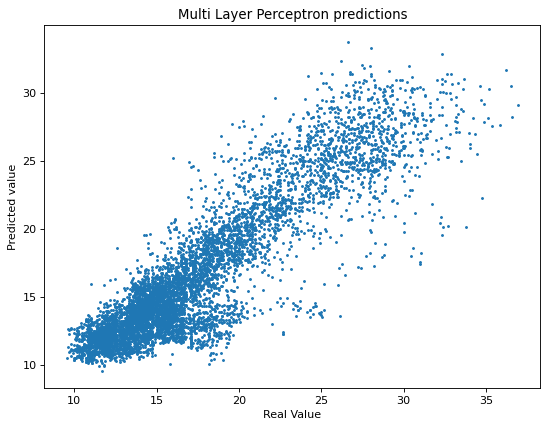

In [131]:
estimator = MLPRegressor(hidden_layer_sizes=5, solver = 'lbfgs', max_iter=3000, learning_rate_init=0.1, random_state=42).fit(inputXscaled, inputy)
y_pred = estimator.predict(testXscaled)

MLPMAPE = mean_absolute_percentage_error(testy, y_pred) * 100
print(MLPMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(testy,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Multi Layer Perceptron predictions')
# Display a figure.
plt.show()

9.876182942578653


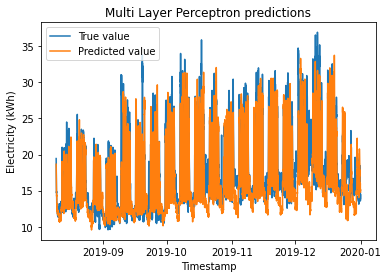

In [132]:
pred = estimator.predict(testXscaled)

MLPMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(MLPMAPE)

plt.title('Multi Layer Perceptron predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

# Adding more features

In [167]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)
df

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


In [168]:
lagNumberStart = 48
lagNumberEnd = 8*48

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(i)
    df[name] = df['HH Electricity (kWh)'].shift(i)

i = list(range(lagNumberEnd))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xused)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['HH Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['HH Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['HH Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)


In [ ]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(inputXscaled, inputy)
y_pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(testy,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

In [ ]:
pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(RandomForestMAPE)

plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

# Random Split

In [26]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
# X = df[feature_cols].copy() #input features for fitting
# Y = df[['HH Electricity (kWh)']]


scaler = StandardScaler() #scaling
scaler.fit(inputX)
Xscaled = scaler.transform(inputX)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Xscaled,inputy,test_size=0.20,random_state=42) #split training:testing 80:20


5.316951974114549


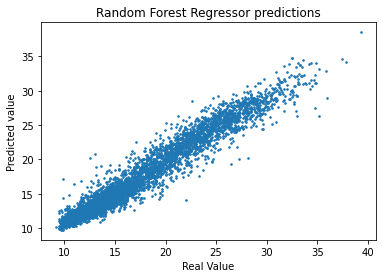

In [28]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

7.660354705268234


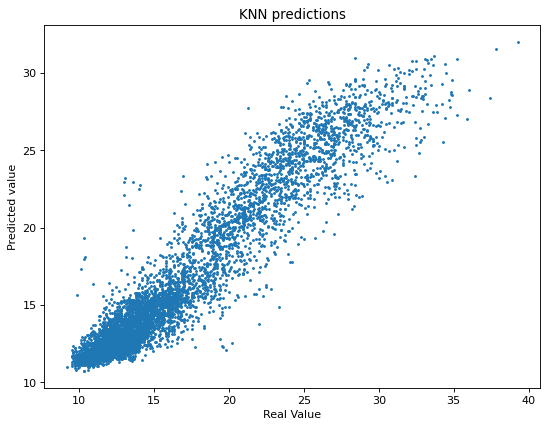

In [29]:
estimator = KNeighborsRegressor(n_neighbors = 104, weights = 'distance').fit(X_train, y_train)
y_pred = estimator.predict(X_test)

KNNMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(KNNMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('KNN predictions')
# Display a figure.
plt.show()

7.33279990522698


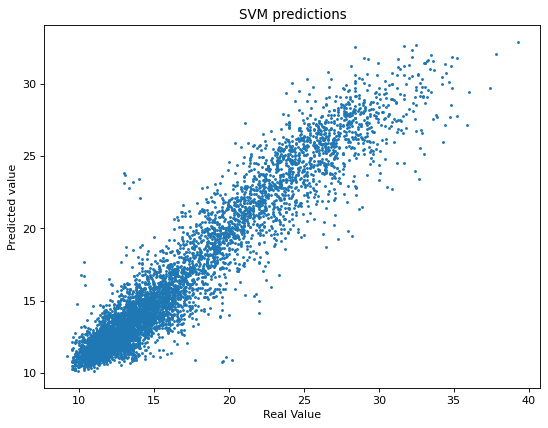

In [30]:
estimator = svm.SVR(C = 1,  kernel = 'rbf', epsilon = 0.1).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

SVMMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions')
# Display a figure.
plt.show()

In [31]:
from sklearn.neural_network import MLPRegressor

layers = range(1,30)

parameters = {'hidden_layer_sizes': layers, 'solver': ['lbfgs', 'adam'], 'max_iter': [2500], 'learning_rate_init': 10.0 ** -np.arange(1, 6, 2), 'random_state':[42]}
MLPReg = GridSearchCV(MLPRegressor(), parameters, cv=5,  verbose=2, return_train_score=False)
MLPReg.fit(X_train, y_train)

MLPRegRes = pd.DataFrame(MLPReg.cv_results_)
MLP_results = MLPRegRes[['rank_test_score', 'mean_test_score', 'param_hidden_layer_sizes', 'param_solver', 'param_max_iter', 'param_learning_rate_init']].sort_values(by=['rank_test_score'])
MLP_results

Fitting 5 folds for each of 174 candidates, totalling 870 fits
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   0.3s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   0.5s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   0.6s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   0.6s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   0.4s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.8s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam;

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=  58.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=  58.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=  58.6s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.0s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.2s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   0.8s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.8s
[CV] END hidden_layer_sizes=2, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.6s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.2s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.3s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.5s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.2s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.8s
[CV] END hidden_layer_sizes=3, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=   0.1s


KeyboardInterrupt: 

8.651299180604703


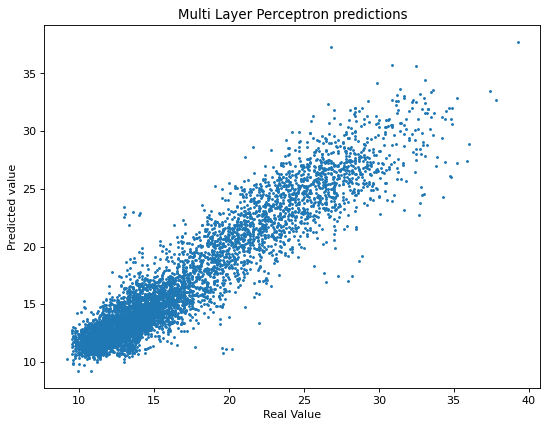

In [33]:
estimator = MLPRegressor(hidden_layer_sizes=5, solver = 'lbfgs', max_iter=3000, learning_rate_init=0.1, random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

MLPMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(MLPMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Multi Layer Perceptron predictions')
# Display a figure.
plt.show()